## Planejamento da solução (IoT)

### Input

1. Business case
    * Customer segmentation
2. Data set
    * the last six months with approximately 9k customers active credit card.
        - There are 18 columns.

### Output

1. Data Analysis


2. Reports with the answers to busisness questions

    1. Create a customer segmentation based on clear selection criteria.
        - RMF
    2. Make customer segmentation accessible to the operations team.
        - Dashboard
        - Streamlit
        - Metabase
    3. Teach the operations team how to use your solution.
    4. Transfer knowledge to International Bank Data Scientists.
    5. Recommend 2-3 business levers for each customer segment.

3. Machine learning algorithm available in an API


### Tasks

- Data Description 
    - Replace NA
.
- EDA

    - Univariate Analisys.
    - Bivariate Analisys.
    - Multivariate Analisys.
    - Check outlier
    - Space study
    - Embedding definition
.
- ML Training

    - Performance analysis.
    - Cluster analysis.
    - The definition of the cluster numbers.
.
- EDA Insights Analysis
    - Explanation about segmentations' features.
    - Cloud architecture with diagrams(https://diagrams.mingrammer.com/docs/getting-started/examples)
        - AWS architecture.
         - S3 store data 
         - EC2 store ETL and visualization tools.
         - DB 
         - Cronjob analysis
         - Papermill


- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

# 0.0 IMPORTS

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML
import inflection
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats               import chi2_contingency,shapiro
import sweetviz as sv
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn import metrics as m
from sklearn import ensemble as en

## 0.1 Helper Functions

In [2]:
def descriptive_statistics(df1_num):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading dataset

In [3]:
df_raw=pd.read_csv('/home/tc0019/DS/bank_marketing/data/raw/CC_GENERAL.csv')
df_raw.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 1.0 Data Description

In [4]:
df1=df_raw.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## 1.1 Rename columns

In [5]:
df1.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [6]:
cols_old=['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

df1.columns=cols_new

df1.sample()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
1656,C11710,3414.977831,1.0,2219.55,1695.03,524.52,950.424076,0.916667,0.75,0.75,0.583333,10,33,5000.0,732.08134,893.816089,0.0,12


## 1.2. Data Dimensions

In [7]:
rows_,columns_=df1.shape

print(f'Number of Rows: {rows_} \nNumber of Cols: {columns_}')

Number of Rows: 8950 
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

### 1.4.1 Remove NA
    - The missing values of minimum_payments can be replaced to 0
        - check inadinplance 

In [10]:
df1 = df1.dropna(subset=['credit_limit', 'minimum_payments'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

Removed data: 0.04


In [11]:
df1.isna().sum()


cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [12]:
df1.shape

(8636, 18)

## 1.5. Descriptive Statistics

In [13]:
df1_num=df1.select_dtypes(include=['int64', 'float64']).round(2)
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [14]:
descriptive_statistics(df1_num)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
balance,0.0,19043.14,19043.14,1601.224885,916.855,2095.449946,2.374254,7.553877,not normal
balance_frequency,0.0,1.0,1.0,0.895212,1.0,0.207915,-2.095833,3.420292,not normal
purchases,0.0,49039.57,49039.57,1025.433874,375.405,2166.982511,8.055789,108.677684,not normal
oneoff_purchases,0.0,40761.25,40761.25,604.901438,44.995,1684.210284,9.935776,160.121308,not normal
installments_purchases,0.0,22500.0,22500.0,420.843533,94.785,917.192075,7.216133,94.193373,not normal
cash_advance,0.0,47137.21,47137.21,994.175518,0.0,2121.335471,5.139629,52.143521,not normal
purchases_frequency,0.0,1.0,1.0,0.495884,0.5,0.401547,0.033127,-1.638517,not normal
oneoff_purchases_frequency,0.0,1.0,1.0,0.20564,0.08,0.300262,1.505065,1.059185,not normal
purchases_installments_frequency,0.0,1.0,1.0,0.368951,0.17,0.398244,0.487376,-1.41975,not normal
cash_advance_frequency,0.0,1.5,1.5,0.137373,0.0,0.20192,1.797457,3.187502,not normal


# 2.0 EDA

In [15]:
df2=df1.copy()


## 2.1 Sweet Viz

In [16]:
# my_report=sv.analyze(df2)
# my_report.show_html()

- CUSTID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases (Limit left to spend)
- BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFFPURCHASES : Maximum purchase amount done in one-go (to pay next month)
- INSTALLMENTSPURCHASES : Amount of purchase done in installment
- CASHADVANCE : Cash in advance given by the user (ATM)
- PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASESTRX : Numbe of purchase transactions made
- CREDITLIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

## 2.2 Univariate Analysis

BALANCE
The definitions is not clear

- Balance is the limit left to spend 
- Current bill 

Considering that some customers have high limits the values that appear here may not be outliers.

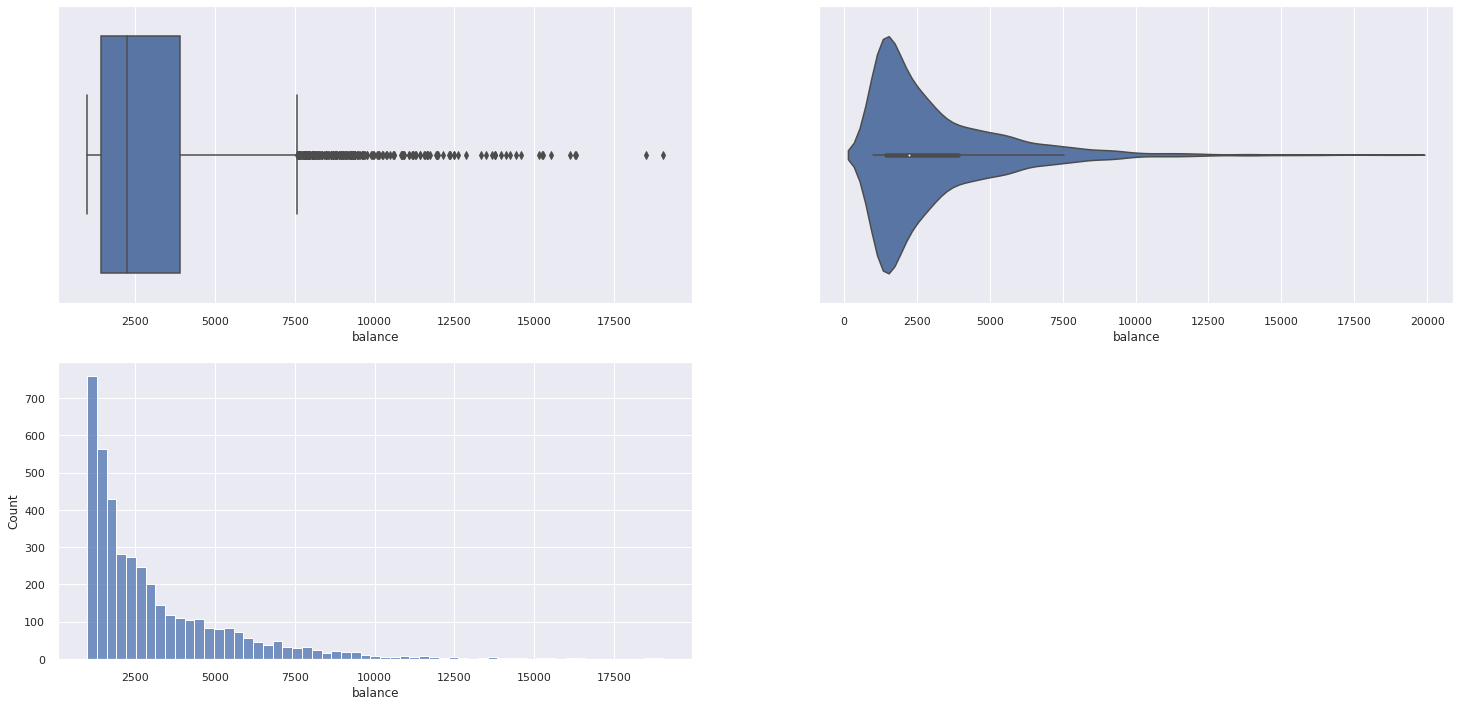

In [17]:
aux= df2.query('balance > 1000')


plt.subplot(2,2,1)
sns.boxplot(x='balance', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='balance', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='balance', data=aux);
# df2.balance.describe()

BALANCE FREQUENCY
- How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

It seems that the customers frequently use their credit card. The customers with not frequently updated balance may be just have the card and use another.

May have outliers

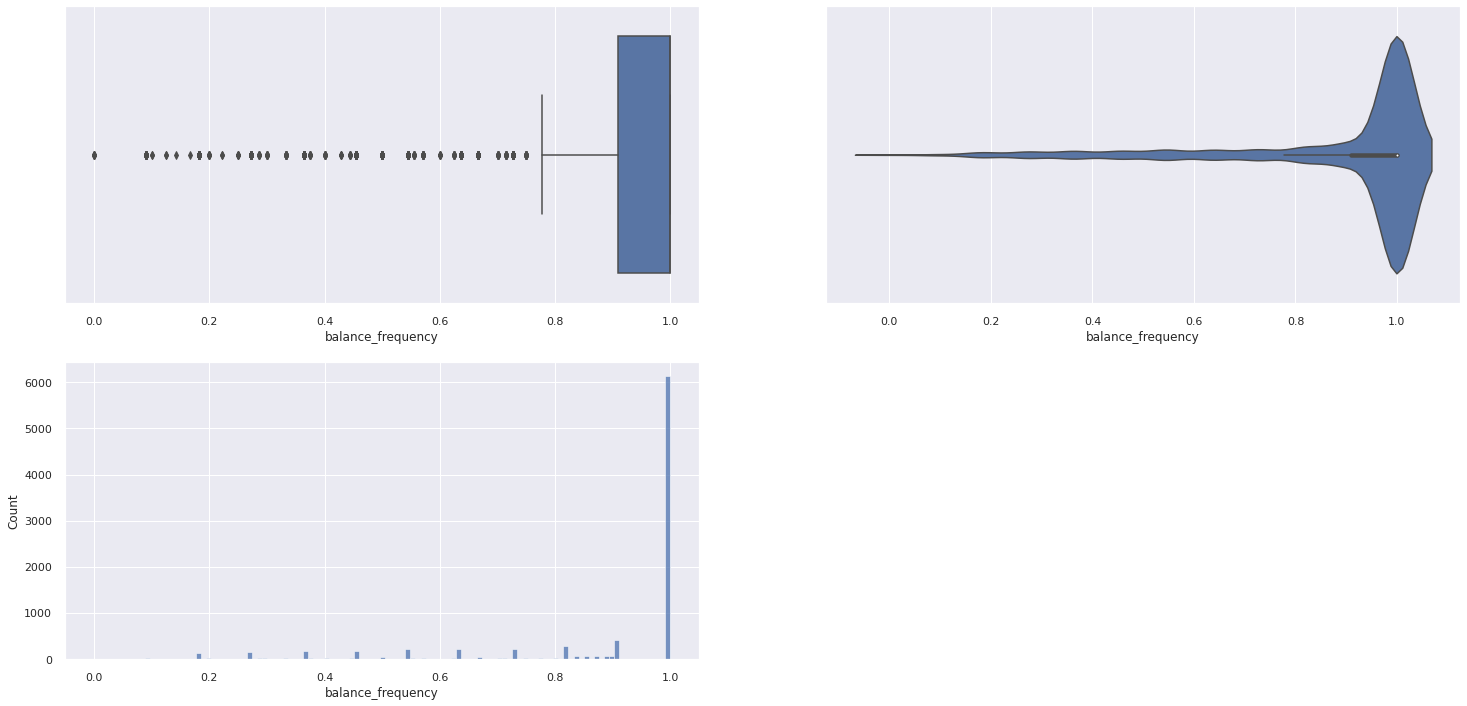

In [18]:
aux= df2#.query('balance < 1.0')


plt.subplot(2,2,1)
sns.boxplot(x='balance_frequency', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='balance_frequency', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='balance_frequency', data=aux);
# df2.balance.describe()

PURCHASES

- Amount of purchases made from account

The customers with high amount of purchases do not seem to be outliers


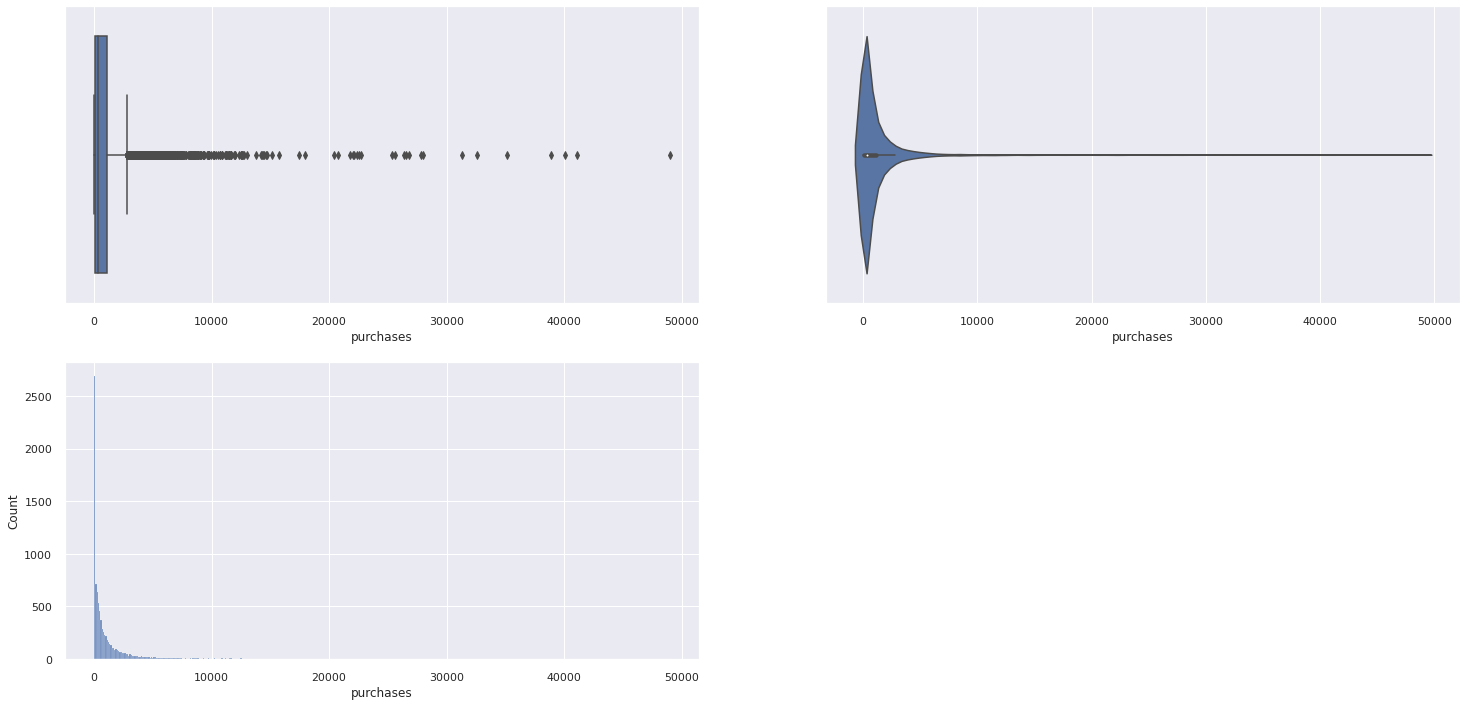

In [19]:
aux= df2#.query('purchases > 10145')


plt.subplot(2,2,1)
sns.boxplot(x='purchases', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='purchases', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='purchases', data=aux);
# df2.purchases.describe()

In [20]:
aux.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


ONEOFFPURCHASES

- Maximum purchase amount done in one-go
- The amount, limit and frequency seems right

May have outliers 

count     8636.000000
mean      1601.224893
std       2095.571300
min          0.000000
25%        148.095189
50%        916.855459
75%       2105.195853
max      19043.138560
Name: balance, dtype: float64

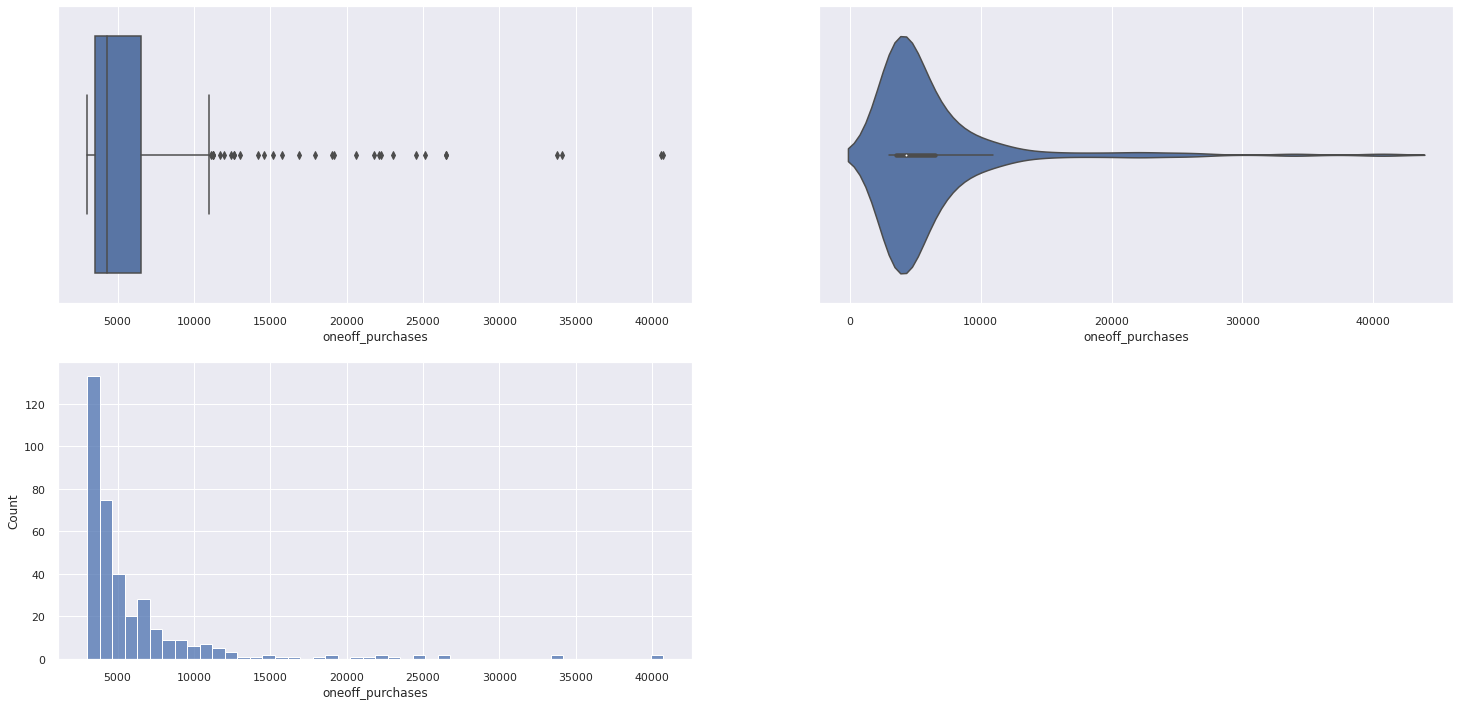

In [21]:
aux= df2.query('oneoff_purchases > 3000')


plt.subplot(2,2,1)
sns.boxplot(x='oneoff_purchases', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='oneoff_purchases', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='oneoff_purchases', data=aux);
df2.balance.describe()

In [22]:
aux.head().round(2)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
6,C10007,627.26,1.00,7091.01,6402.63,688.38,0.00,1.00,1.00,1.00,0.00,0,64,13500.0,6354.31,198.07,1.00,12
21,C10022,6369.53,1.00,6359.95,5910.04,449.91,229.03,1.00,0.92,1.00,0.33,6,92,11250.0,2077.96,1659.78,0.00,12
23,C10024,3800.15,0.82,4248.35,3454.56,793.79,7974.42,1.00,0.08,0.92,0.33,13,13,9000.0,9479.04,1425.43,0.00,12
57,C10059,2386.33,1.00,5217.62,4789.09,428.53,0.00,0.92,0.92,0.50,0.00,0,42,7500.0,5678.73,1311.51,0.08,12
84,C10088,1935.36,1.00,4915.60,4515.34,400.26,293.84,1.00,1.00,0.33,0.08,1,50,9000.0,4921.07,594.76,0.00,12


In [23]:
df2['oneoff_purchases']=df2['oneoff_purchases'].astype(int)
df2['credit_limit']=df2['credit_limit'].astype(int)

In [24]:
aux10=df2.copy()
aux10['outliers_oneoff_limitcredit'] = np.where(df2['oneoff_purchases'] > df2['credit_limit'], 'possible_outlier', 'normal_user')

In [25]:
aux10.query('outliers_oneoff_limitcredit == "possible_outlier"').round(2).head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,outliers_oneoff_limitcredit
125,C10131,2392.92,1.0,12462.44,12462,0.00,0.00,0.92,0.92,0.00,0.00,0,217,2800,11628.72,2000.99,0.00,12,possible_outlier
204,C10212,4559.78,1.0,10848.50,8208,2640.50,0.00,1.00,0.67,1.00,0.00,0,123,7500,9423.72,2925.28,0.00,12,possible_outlier
224,C10233,6571.48,1.0,9325.22,9325,0.00,0.00,0.33,0.33,0.00,0.00,0,5,8500,11036.73,1824.68,0.00,12,possible_outlier
262,C10273,2041.48,1.0,7323.38,4944,2378.50,191.33,1.00,0.83,0.75,0.08,1,81,3000,3792.10,1737.89,0.08,12,possible_outlier
273,C10284,5131.32,1.0,32539.78,26547,5992.35,0.00,1.00,1.00,1.00,0.00,0,98,11500,26652.34,1971.13,0.08,12,possible_outlier


CASHADVANCE 

- The option of take credit money in a ATM
- Studying this feature, the point that caught my attention is the fact that this way of borrowing money from the bank brings a lot of taxes to the customer
- The customers whose used cas in advance have a cash_advance_trx in right way 

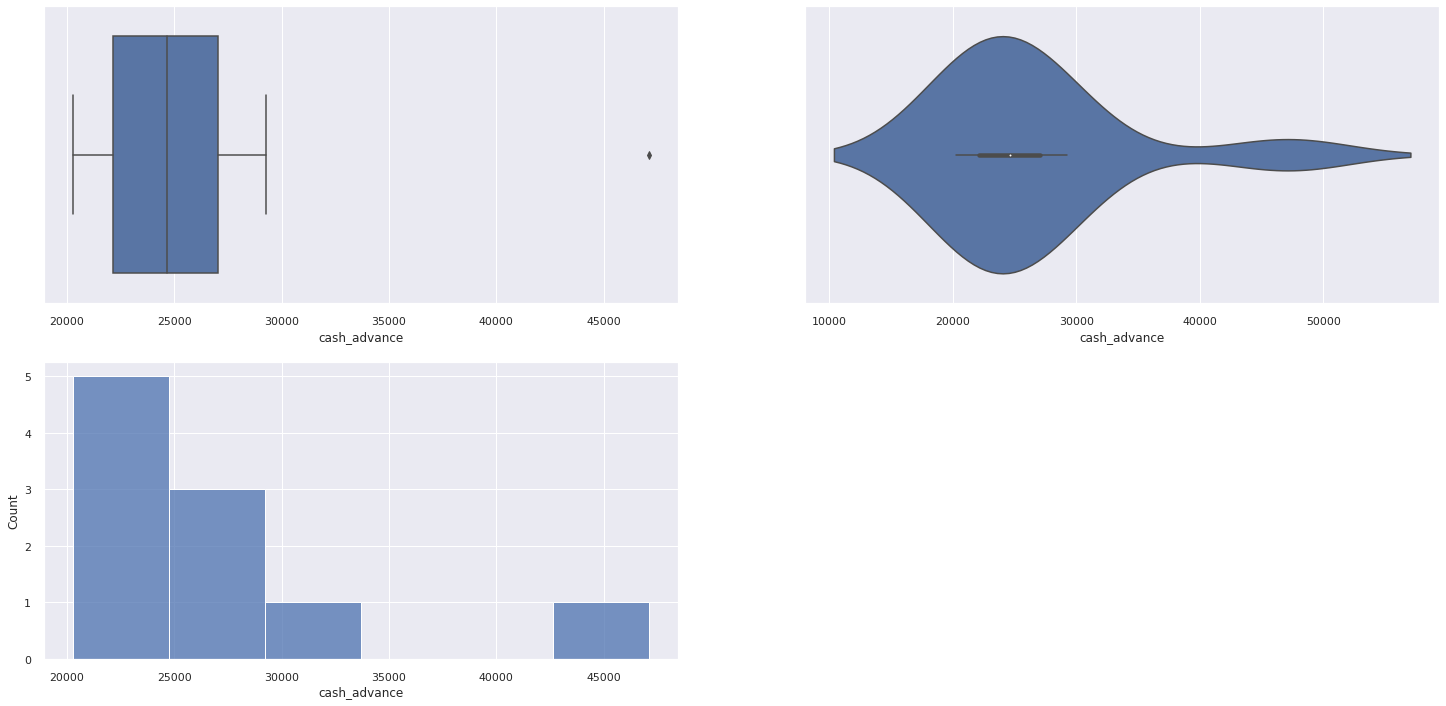

In [26]:
aux= df2.query('cash_advance > 20000')


plt.subplot(2,2,1)
sns.boxplot(x='cash_advance', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='cash_advance', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='cash_advance', data=aux);
# df2.balance.describe()

In [27]:
aux.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
71,C10074,2990.422186,0.909091,4523.27,1664,2859.18,27296.48576,0.666667,0.50,0.583333,0.833333,27,33,7000,28232.69446,1107.030803,0.454545,12
883,C10914,14581.459140,1.000000,0.00,0,0.00,22665.77850,0.000000,0.00,0.000000,0.833333,30,0,18500,20941.32551,5433.759888,0.000000,12
1059,C11094,8823.284205,1.000000,3719.00,2293,1425.82,29282.10915,1.000000,0.75,1.000000,0.416667,26,61,15500,28150.97869,7321.639932,0.083333,12
2159,C12226,10905.053810,1.000000,431.93,133,298.43,47137.21176,0.583333,0.25,0.500000,1.000000,123,21,19600,39048.59762,5394.173671,0.000000,12
2454,C12528,10915.550750,1.000000,0.00,0,0.00,23130.82106,0.000000,0.00,0.000000,0.583333,23,0,15000,18341.95467,3127.192305,0.000000,12


CASHADVANCETRX
The definitions is not clear

- Number of Transactions made with "Cash in Advanced"
- The customers whose took money are making trx with it

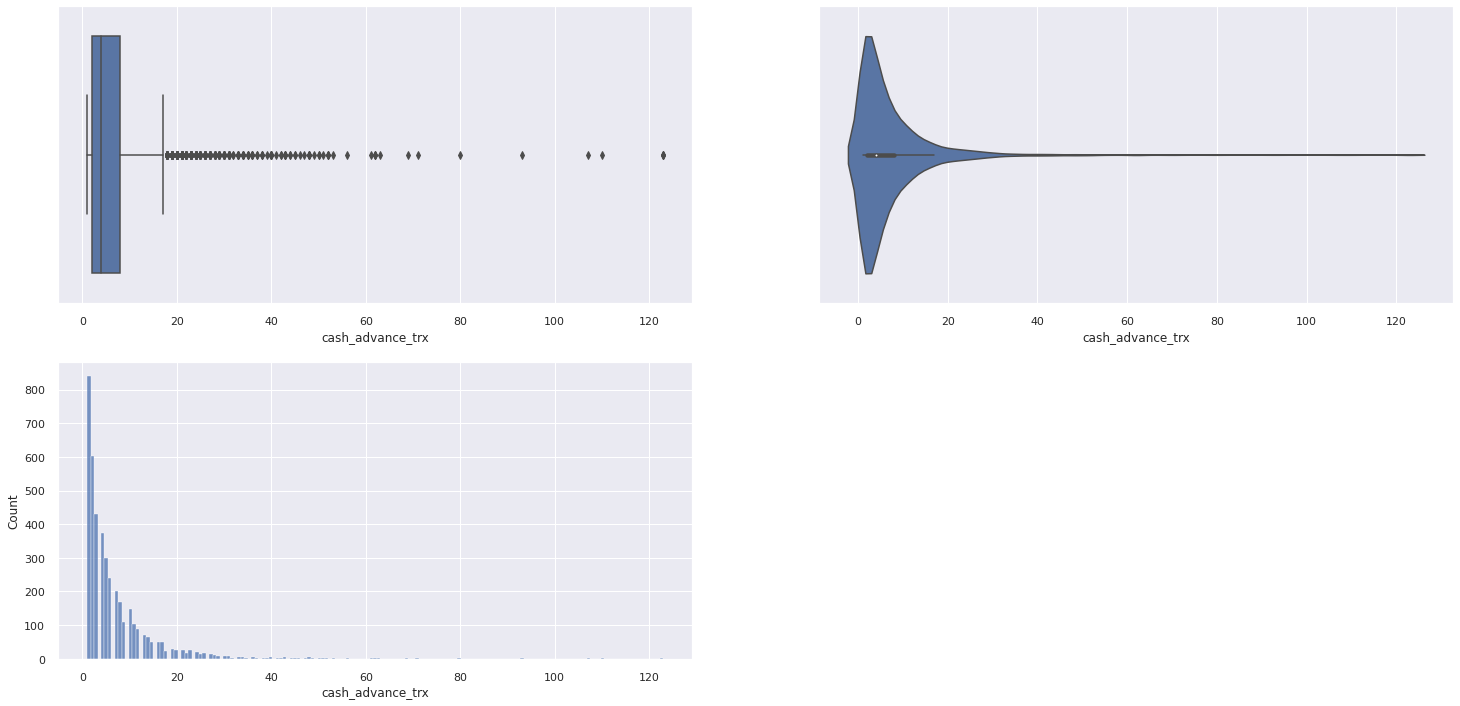

In [28]:
aux= df2.query('cash_advance_trx > 0')


plt.subplot(2,2,1)
sns.boxplot(x='cash_advance_trx', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='cash_advance_trx', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='cash_advance_trx', data=aux);
# df2.balance.describe()

PURCHASESTRX

- Number of purchase transactions made


May have outliers

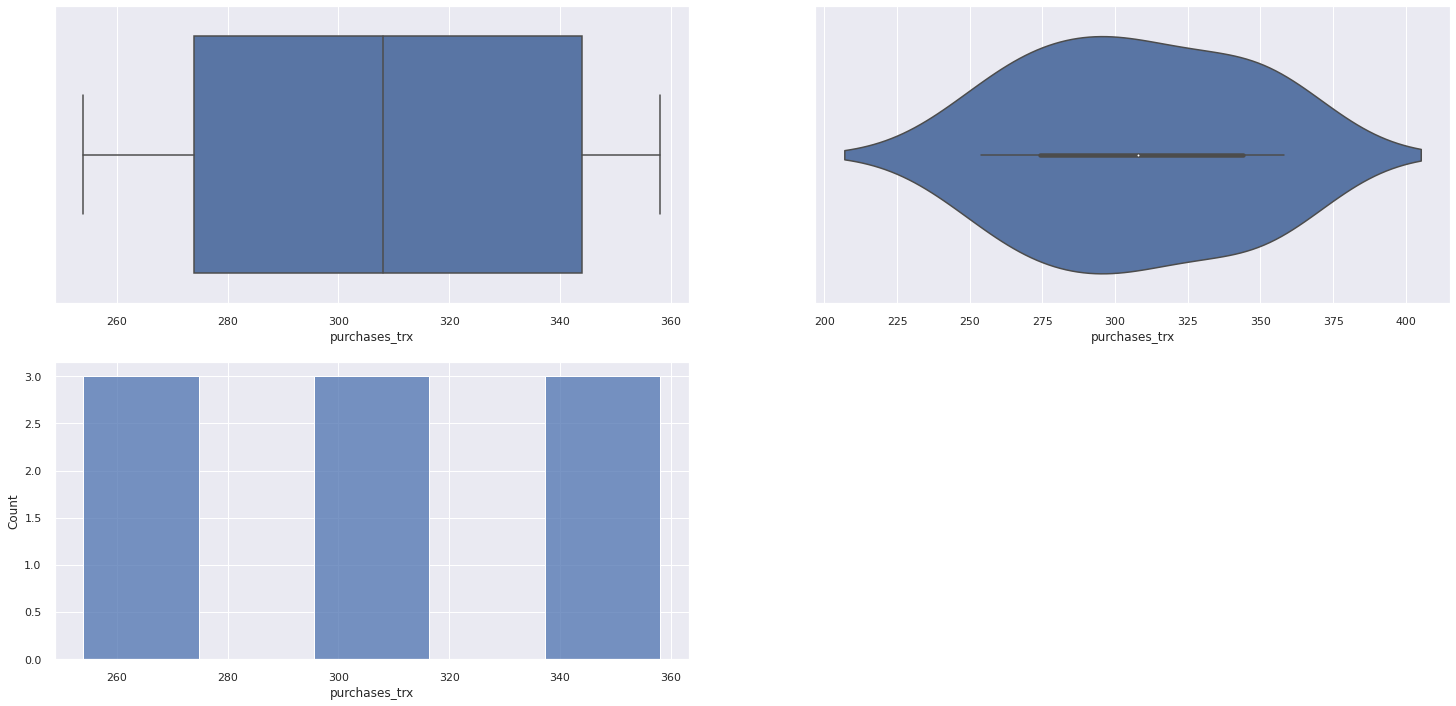

In [29]:
aux= df2.query('purchases_trx > 250')


plt.subplot(2,2,1)
sns.boxplot(x='purchases_trx', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='purchases_trx', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='purchases_trx', data=aux);
# df2.balance.describe()

In [30]:
aux.head().round(2)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
1256,C11300,4010.62,1.0,40040.71,24543,15497.19,0.00,1.0,1.00,1.0,0.00,0,358,18000,33994.73,703.50,1.00,12
1912,C11974,5292.91,1.0,5539.68,2603,2935.89,0.00,1.0,0.92,1.0,0.00,0,273,6000,3597.68,3838.48,0.00,12
2515,C12589,3891.35,1.0,3629.80,50,3579.80,2538.56,1.0,0.08,1.0,0.17,5,254,7500,8259.41,4725.47,0.08,12
2823,C12905,11642.60,1.0,15108.47,2370,12738.47,0.00,1.0,0.50,1.0,0.00,0,298,12000,16005.45,11652.57,0.00,12
3181,C13272,11631.32,1.0,14686.10,0,14686.10,3422.72,1.0,0.00,1.0,0.08,2,347,13600,11400.60,10285.13,0.00,12


CREDITLIMIT

- Limit of Credit Card for user


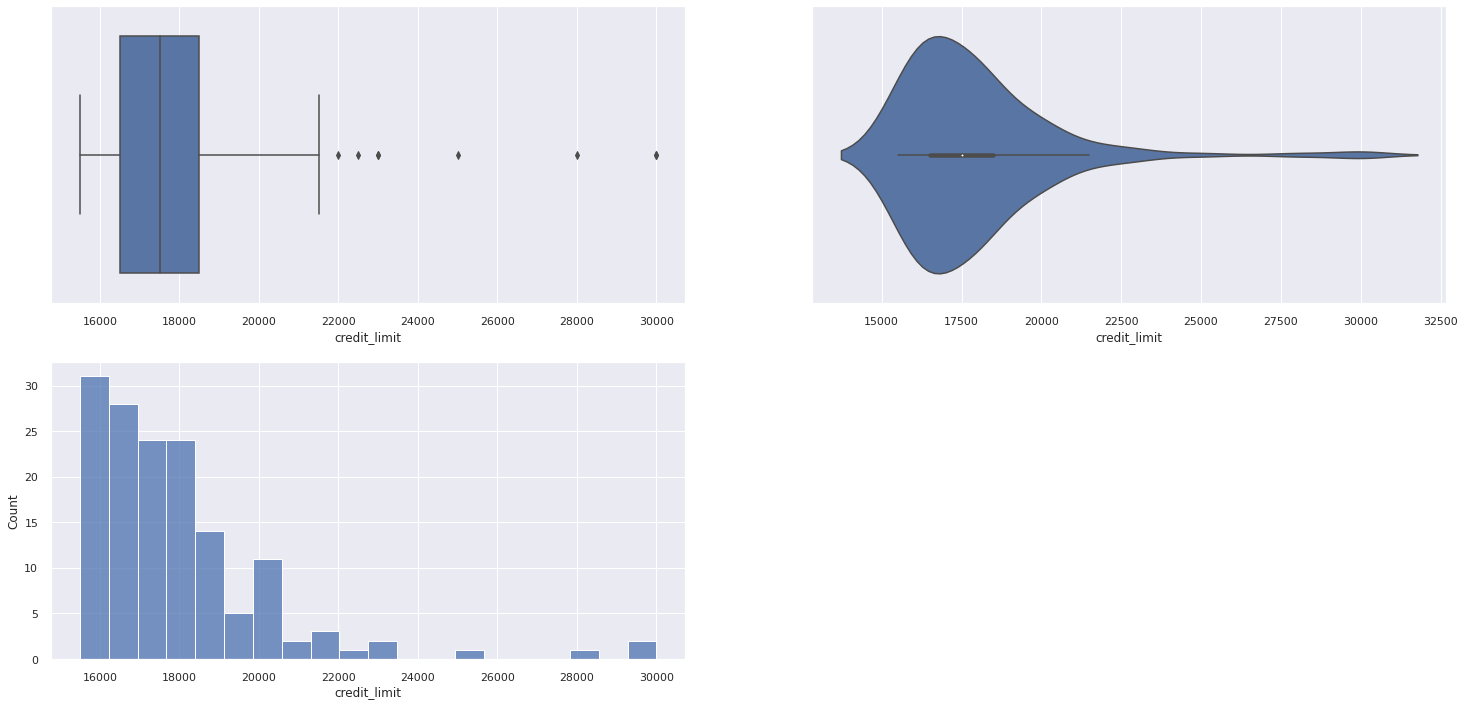

In [31]:
aux= df2.query('credit_limit > 15000')


plt.subplot(2,2,1)
sns.boxplot(x='credit_limit', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='credit_limit', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='credit_limit', data=aux);
# df2.balance.describe()

PAYMENTS

- Amount of Payment done by user


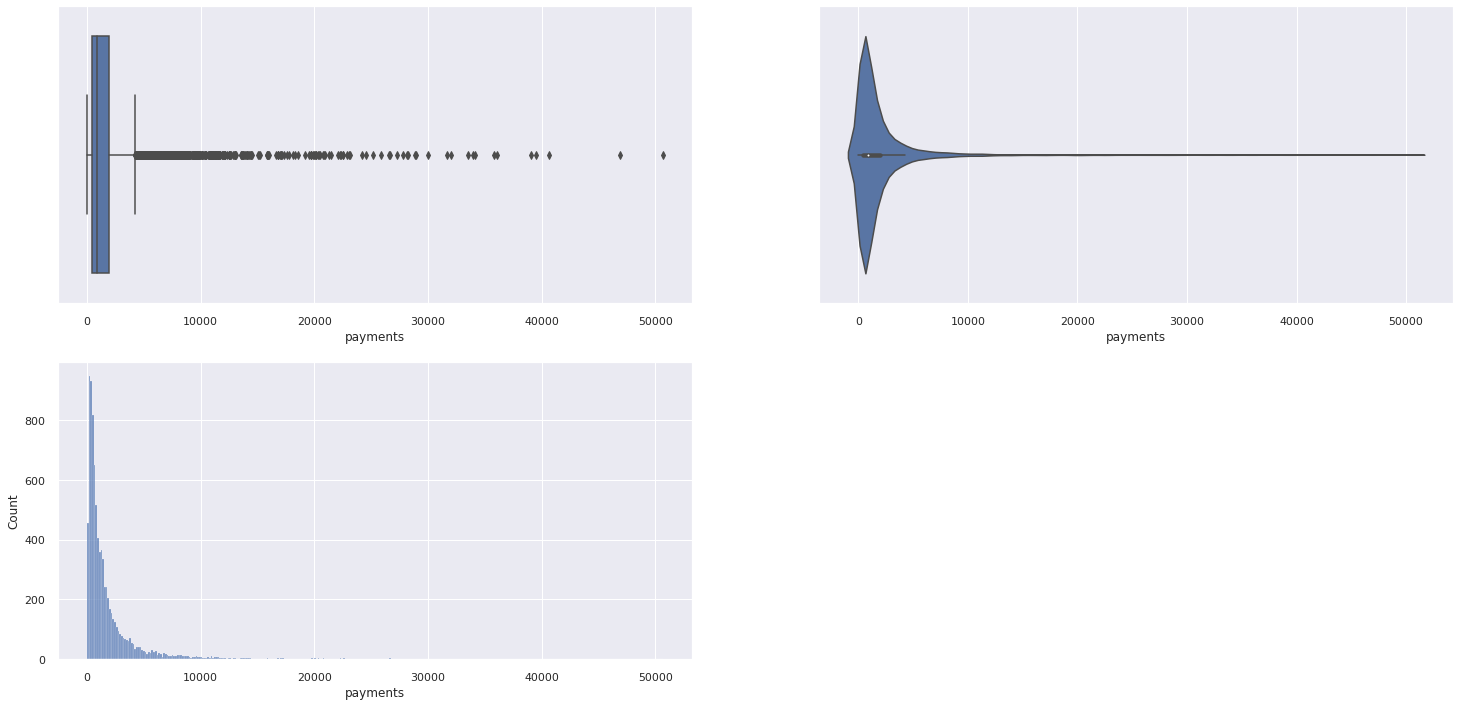

In [32]:
aux= df2#.query('oneoff_payment = 0')


plt.subplot(2,2,1)
sns.boxplot(x='payments', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='payments', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='payments', data=aux);
# df2.balance.describe()

MINIMUM_PAYMENTS

- Minimum amount of payments made by user

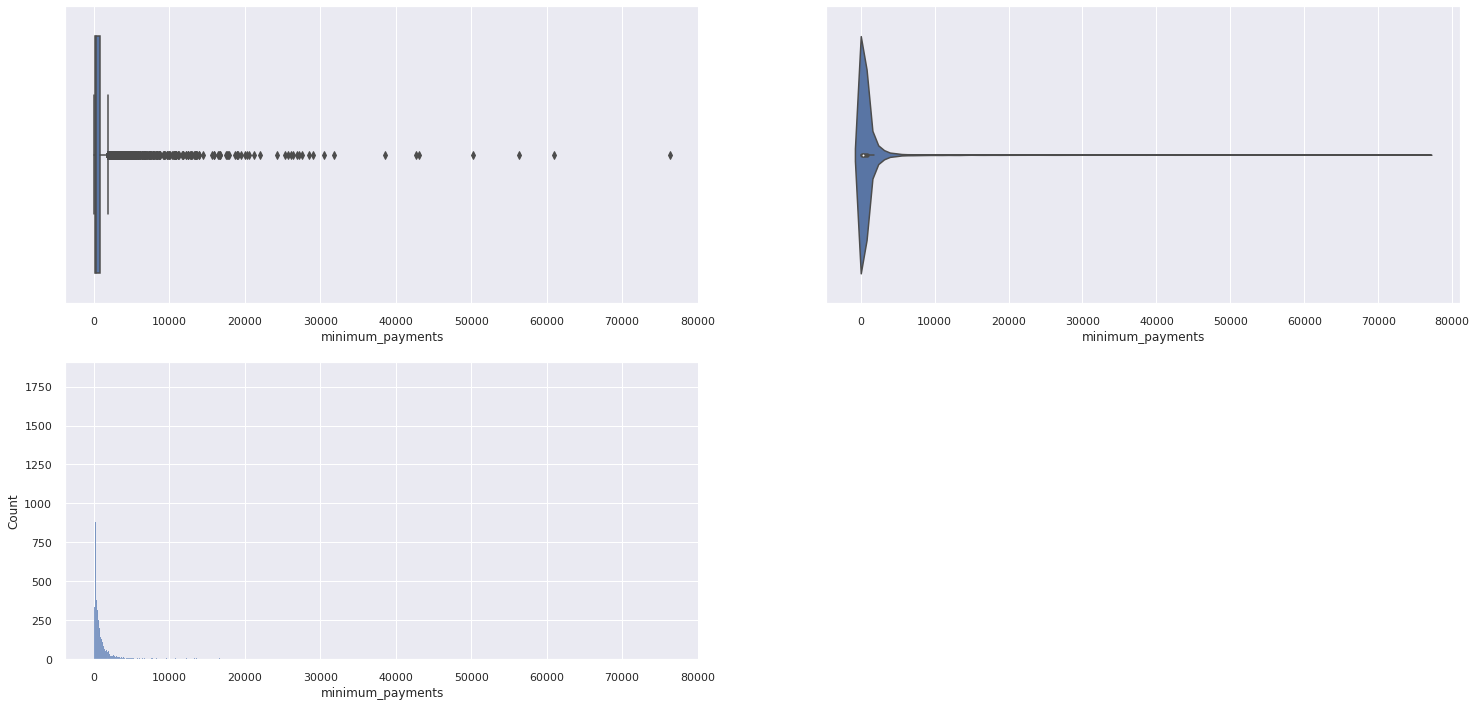

In [33]:
aux= df2#.query('minimum_payments > 250')


plt.subplot(2,2,1)
sns.boxplot(x='minimum_payments', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='minimum_payments', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='minimum_payments', data=aux);
# df2.balance.describe()

PRCFULLPAYMENT

- Percent of full payment paid by user

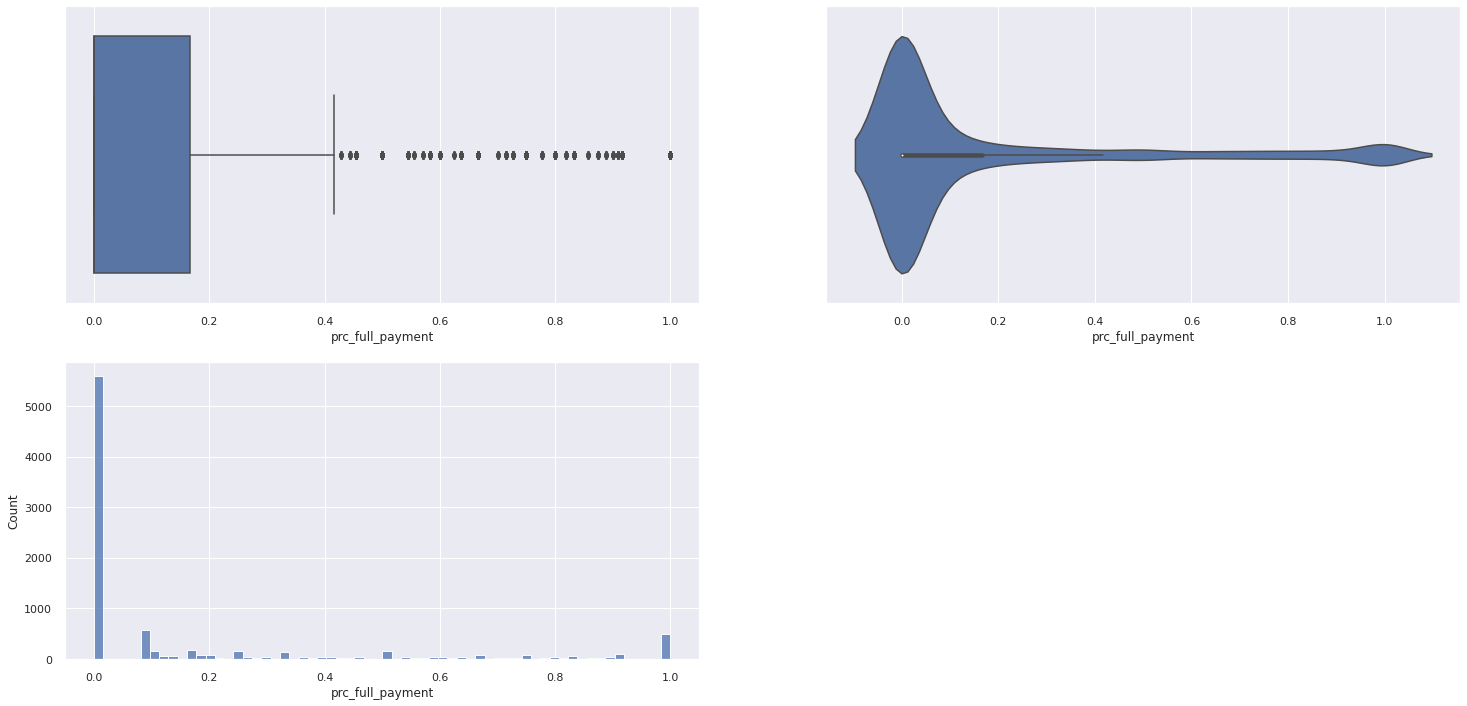

In [34]:
aux= df2#.query('minimum_payments > 250')


plt.subplot(2,2,1)
sns.boxplot(x='prc_full_payment', data=aux);
plt.subplot(2,2,2)
sns.violinplot(x='prc_full_payment', data=aux);
plt.subplot(2,2,3)
sns.histplot(x='prc_full_payment', data=aux);
# df2.balance.describe()

General Histograms

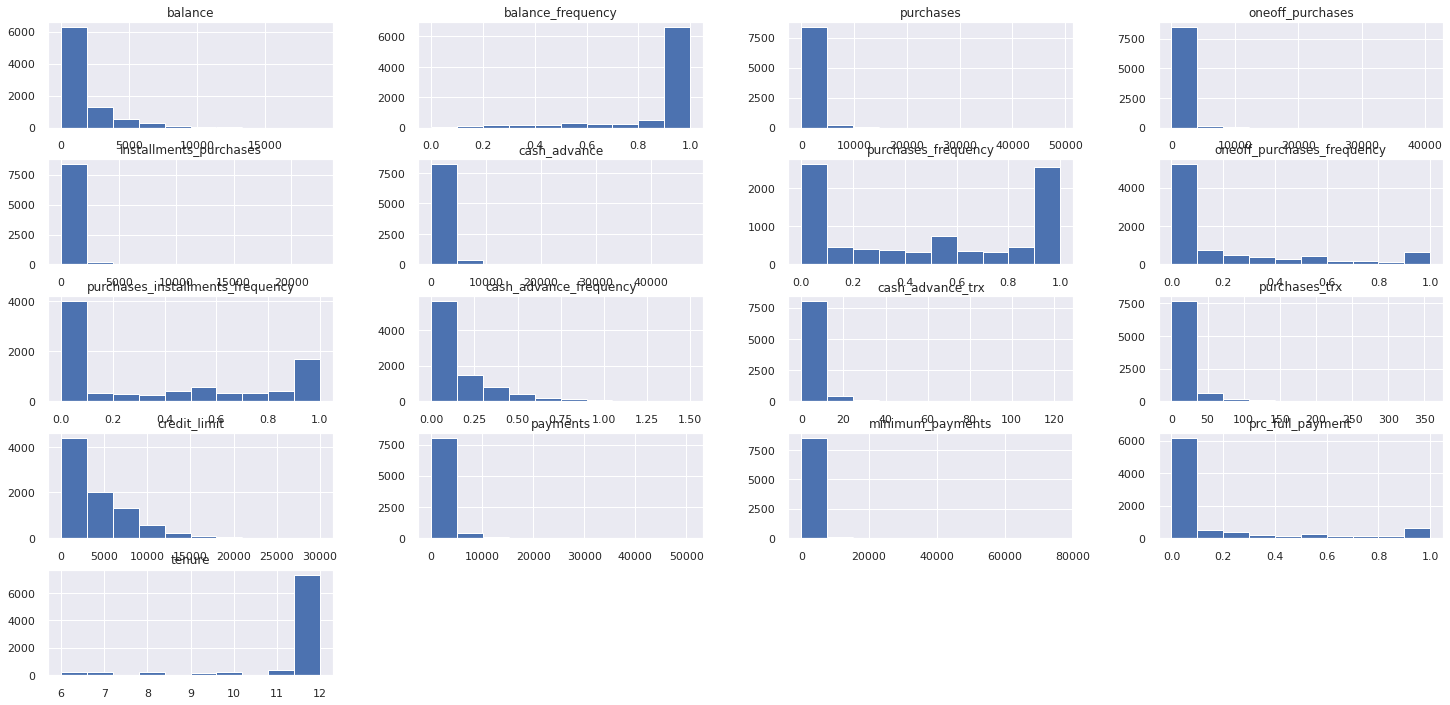

In [35]:
df1_num.hist();

In [36]:
# sns.pairplot(df1);

## 2.3 Multivariate Analysis

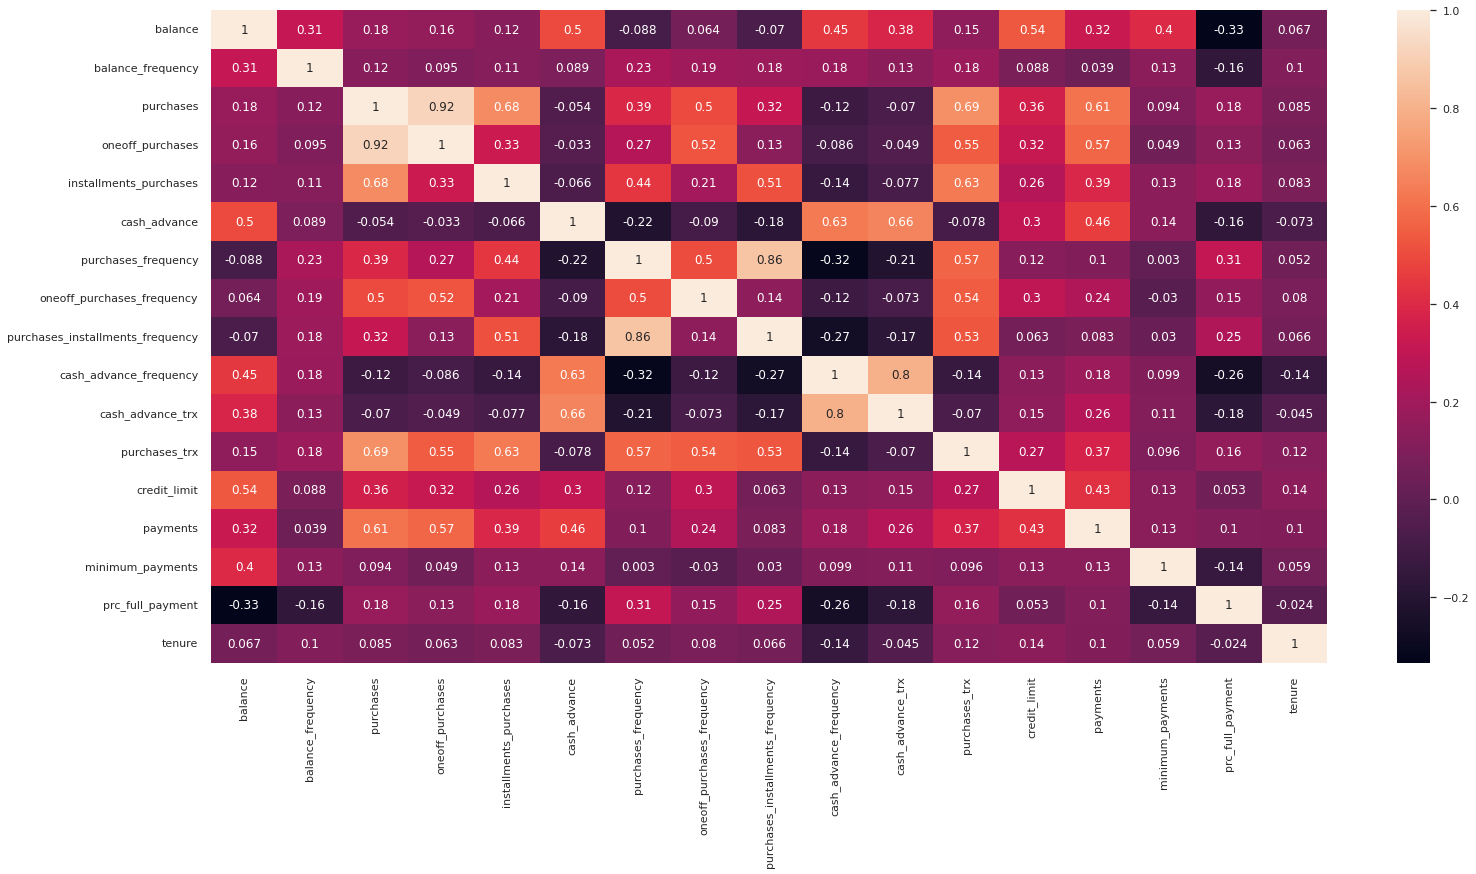

In [37]:
aux=df2.drop(columns=['cust_id'],axis=1)
sns.heatmap(aux.corr( method='pearson' ), annot=True );

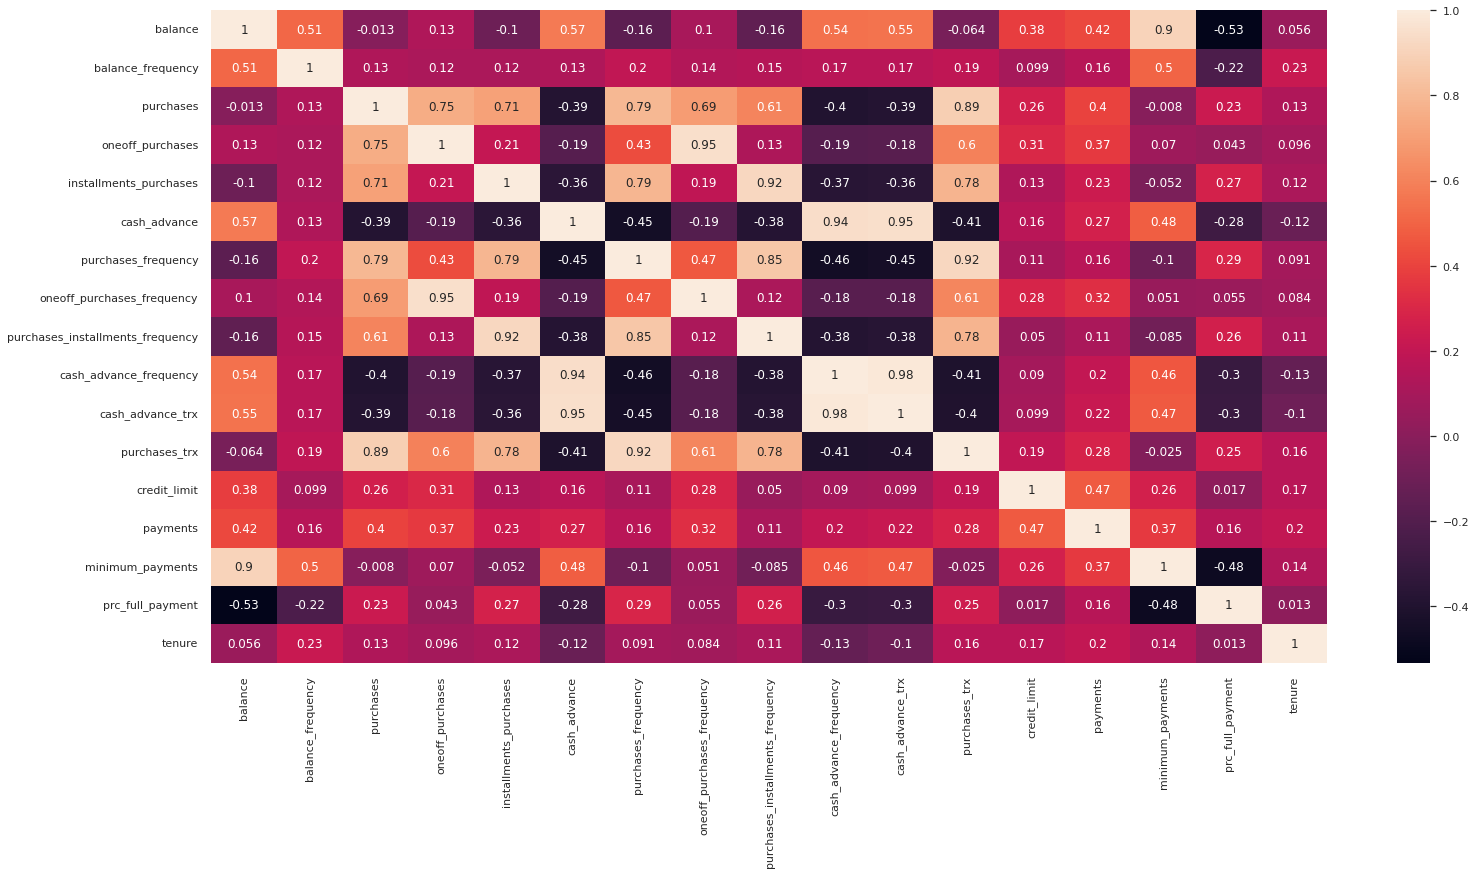

In [38]:
sns.heatmap(aux.corr( method='spearman' ), annot=True );

# 3.0 Data Filtering

In [39]:
df3=df2.copy()

# ['purchases_installments_frequency', 'tenure', 'cash_advance_frequency']

# 4.0 Feature Engineering

In [40]:
df4=df3.copy()

In [41]:
df4.head().round(2)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.90,0.82,95.40,0,95.40,0.00,0.17,0.00,0.08,0.00,0,2,1000,201.80,139.51,0.00,12
1,C10002,3202.47,0.91,0.00,0,0.00,6442.95,0.00,0.00,0.00,0.25,4,0,7000,4103.03,1072.34,0.22,12
2,C10003,2495.15,1.00,773.17,773,0.00,0.00,1.00,1.00,0.00,0.00,0,12,7500,622.07,627.28,0.00,12
4,C10005,817.71,1.00,16.00,16,0.00,0.00,0.08,0.08,0.00,0.00,0,1,1200,678.33,244.79,0.00,12
5,C10006,1809.83,1.00,1333.28,0,1333.28,0.00,0.67,0.00,0.58,0.00,0,8,1800,1400.06,2407.25,0.00,12


In [42]:
df40=df4.copy()


# test with and withou the tenure derivations

# credit_limit by tenure
df40['cred_tenure']=df40['credit_limit']/df40['tenure']
df40['purchase_tenure']=df40['purchases']/df40['tenure']

df40['balance_tenure']=df40['balance']/df40['tenure']
df40['balancefreq_tenure']=df40['balance_frequency']/df40['tenure']

# purchase avg ticket
df40['purchase_avg_ticket']=df40['purchases']/df40['purchases_trx']

# one go payments yes or no (delete )
df40['onego']=df40.oneoff_purchases.apply( lambda x:  0 if x==0.00 else 1)

# total spending(ATM + passing CCard) / trx total purchase
df40['totaltrx_avg_ticket']=(df40['purchases']+df40['cash_advance']) / (df40['purchases_trx']+df40['cash_advance_trx'])

# debt rate payment
df40['debt_rate']=(df40['purchases']+df40['cash_advance']) / (df40['payments']+df40['minimum_payments'])

# limit cc freq
df40['credit_limit_rate']=df40['purchases']+df40['cash_advance'] / (6*df40['credit_limit'])

df40=df40.fillna(0)



### 4.1.2 Isolation Forest

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


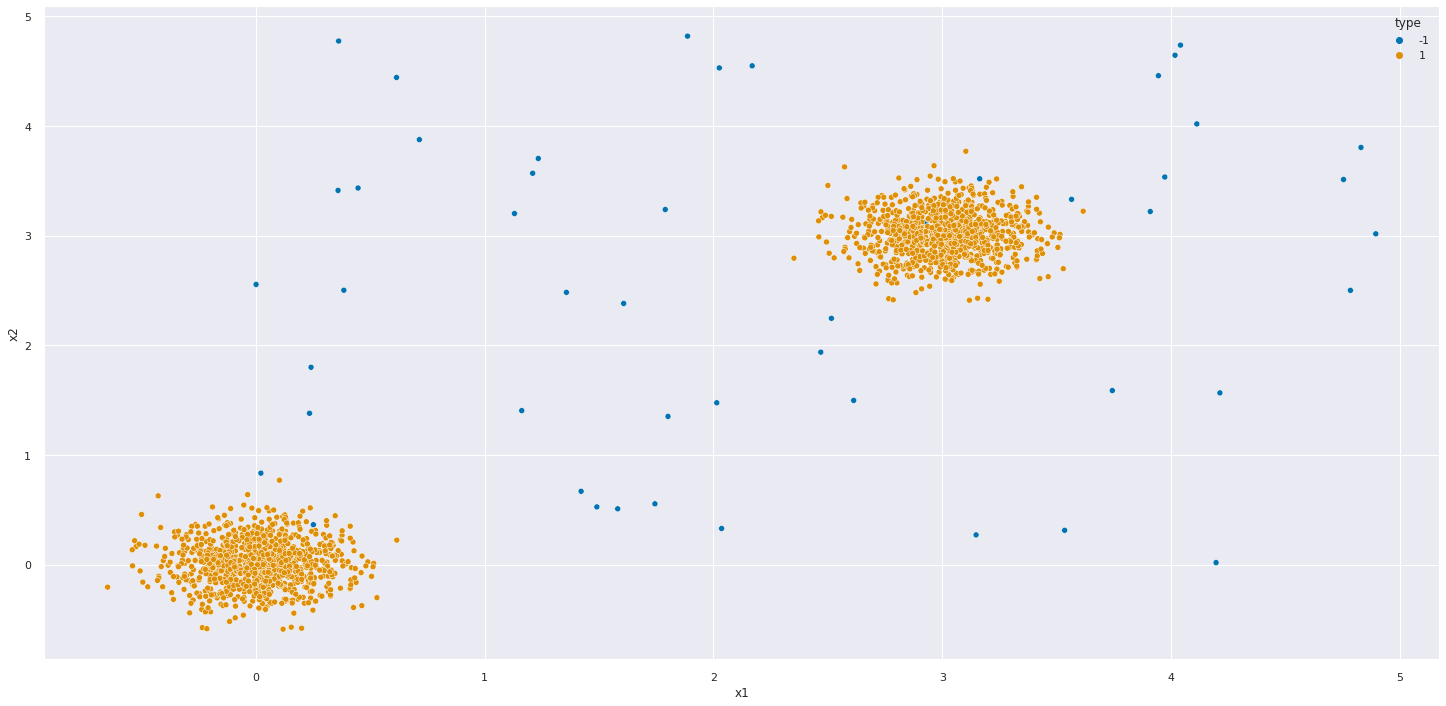

In [43]:
rng = np.random.RandomState(42)

# generating training data
X= 0.2*rng.randn(1000, 2)


# check r_
X=np.r_[X+3, X]
X = pd.DataFrame(X, columns=['x1', 'x2'])
X['type'] = 1

# noise data(outliers)
X_outliers=rng.uniform(low=0, high=5, size=(50,2))
X_outliers=pd.DataFrame(X_outliers, columns=['x1', 'x2'])
X_outliers['type'] = -1

X = pd.concat([X_outliers,X])

sns.scatterplot('x1', 'x2', palette='colorblind',hue='type', data=X);

/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/tc0019/anaconda3/envs/pa05env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


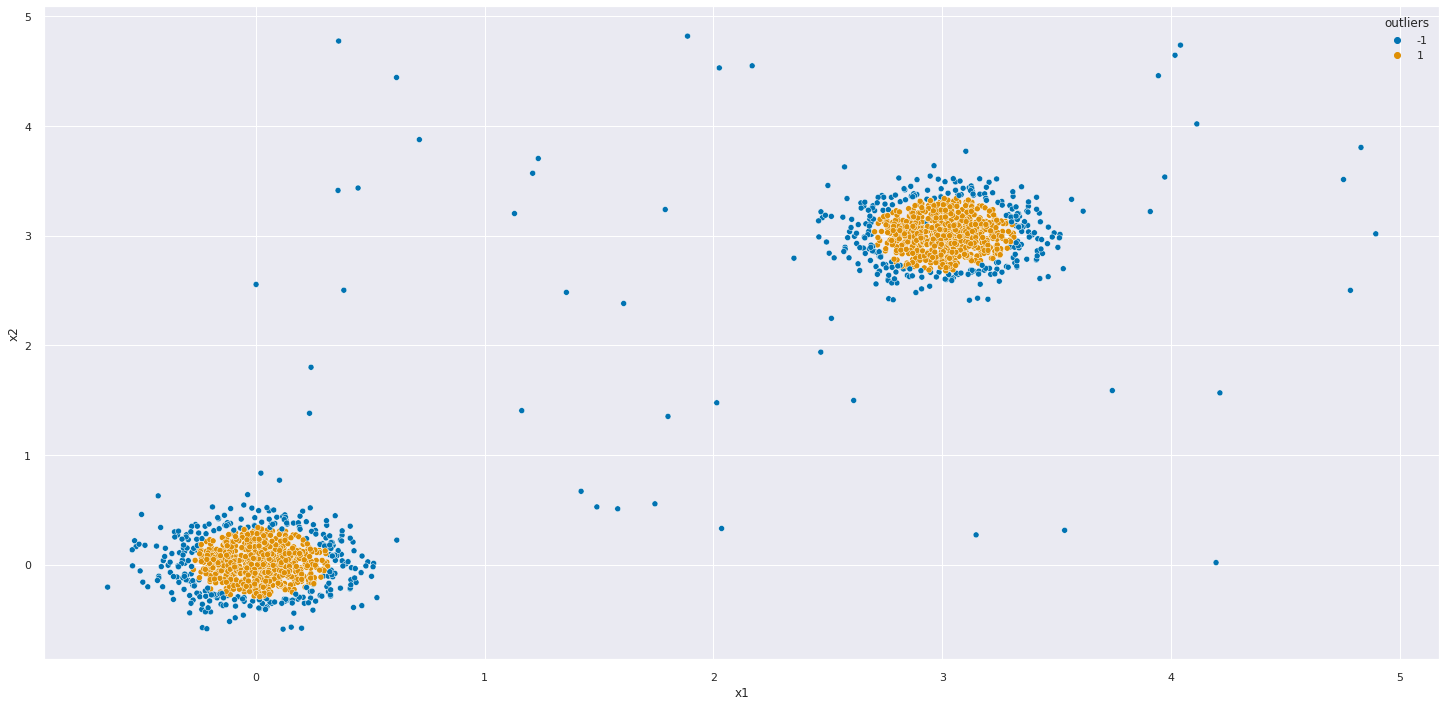

In [44]:
df= X.drop('type', axis=1)


# isolation forest
from sklearn import ensemble as en
# train
iso_model=en.IsolationForest(n_estimators=1300, max_samples=300, bootstrap=True, contamination=0.30, random_state=rng, n_jobs=-1)


# predict
preds = iso_model.fit_predict(X)

# performance
X['outliers']=preds

sns.scatterplot('x1', 'x2', hue='outliers', palette='colorblind', data=X);

# 5.0 Data preparation

In [57]:
df5=df4.copy()
# df5=df40.copy()

In [58]:
df5.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800,1400.057770,2407.246035,0.000000,12


## 5.1 Rescaling

In [59]:
mm= MinMaxScaler()

df5['balance']=mm.fit_transform(df5[['balance']])
df5['purchases']=mm.fit_transform(df5[['purchases']])
df5['oneoff_purchases']=mm.fit_transform(df5[['oneoff_purchases']])
df5['installments_purchases']=mm.fit_transform(df5[['installments_purchases']])
df5['cash_advance']=mm.fit_transform(df5[['cash_advance']])
df5['cash_advance_trx']=mm.fit_transform(df5[['cash_advance_trx']])
df5['purchases_trx']=mm.fit_transform(df5[['purchases_trx']])
df5['credit_limit']=mm.fit_transform(df5[['credit_limit']])
df5['payments']=mm.fit_transform(df5[['payments']])
df5['minimum_payments']=mm.fit_transform(df5[['minimum_payments']])
df5['tenure']=mm.fit_transform(df5[['tenure']])


# 6.0 Feature Selection

In [60]:
df6=df5.copy()

# 7.0 Model Training 

In [61]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,8636.0,0.084084,0.110043,0.000000,0.007777,0.048146,0.110549,1.000000e+00
balance_frequency,8636.0,0.895035,0.207697,0.000000,0.909091,1.000000,1.000000,1.000000e+00
purchases,8636.0,0.020910,0.044191,0.000000,0.000884,0.007655,0.023368,1.000000e+00
oneoff_purchases,8636.0,0.014835,0.041319,0.000000,0.000000,0.001092,0.014677,1.000000e+00
installments_purchases,8636.0,0.018704,0.040766,0.000000,0.000000,0.004213,0.021518,1.000000e+00
cash_advance,8636.0,0.021091,0.045006,0.000000,0.000000,0.000000,0.024023,1.000000e+00
purchases_frequency,8636.0,0.496000,0.401273,0.000000,0.083333,0.500000,0.916667,1.000000e+00
oneoff_purchases_frequency,8636.0,0.205909,0.300054,0.000000,0.000000,0.083333,0.333333,1.000000e+00
purchases_installments_frequency,8636.0,0.368820,0.398093,0.000000,0.000000,0.166667,0.750000,1.000000e+00
cash_advance_frequency,8636.0,0.137604,0.201791,0.000000,0.000000,0.000000,0.250000,1.500000e+00


In [62]:
df7=df6.copy()
X = df6.drop(columns=['cust_id'],axis=1)
clusters = [2, 3, 4, 5, 6, 7, 8]

silhouette_list = []
davies_list = []

for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score (X, labels)
    dav = m.davies_bouldin_score(X, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.3795653750060243
0.3636779686718967
0.3072170207990734
0.3007451652941866
0.27587795037974194
0.31969098726072376
0.29806728372078867


In [63]:
df7=df6.copy()
X1 = df6.drop(columns=['cust_id'],axis=1)
clusters = [2, 3, 4, 5, 6, 7, 8]

silhouette_list = []
davies_list = []

for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X1)

    # model predict
    labels=kmeans_model.predict(X1)

    # model performance
    sil = m.silhouette_score (X1, labels)
    dav = m.davies_bouldin_score(X1, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.3795624909394006
0.3637578365552287
0.3072170207990734
0.30061941334633646
0.2759485191405311
0.3199122019380524
0.2996929531122206


## 7.1 K-means

In [64]:
silhouette_list = []
davies_list = []

for k in clusters:
    # model definition
    kmeans_model=c.KMeans(n_clusters=k)

    # model Training
    kmeans_model.fit(X)

    # model predict
    labels=kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score (X, labels)
    dav = m.davies_bouldin_score(X, labels)

    silhouette_list.append(sil)
    davies_list.append(dav)
    print(sil)

0.3795653750060243
0.3637180599712426
0.3072170207990734
0.3007460185950262
0.3148644428332141
0.31984137936664736
0.30003257610804884


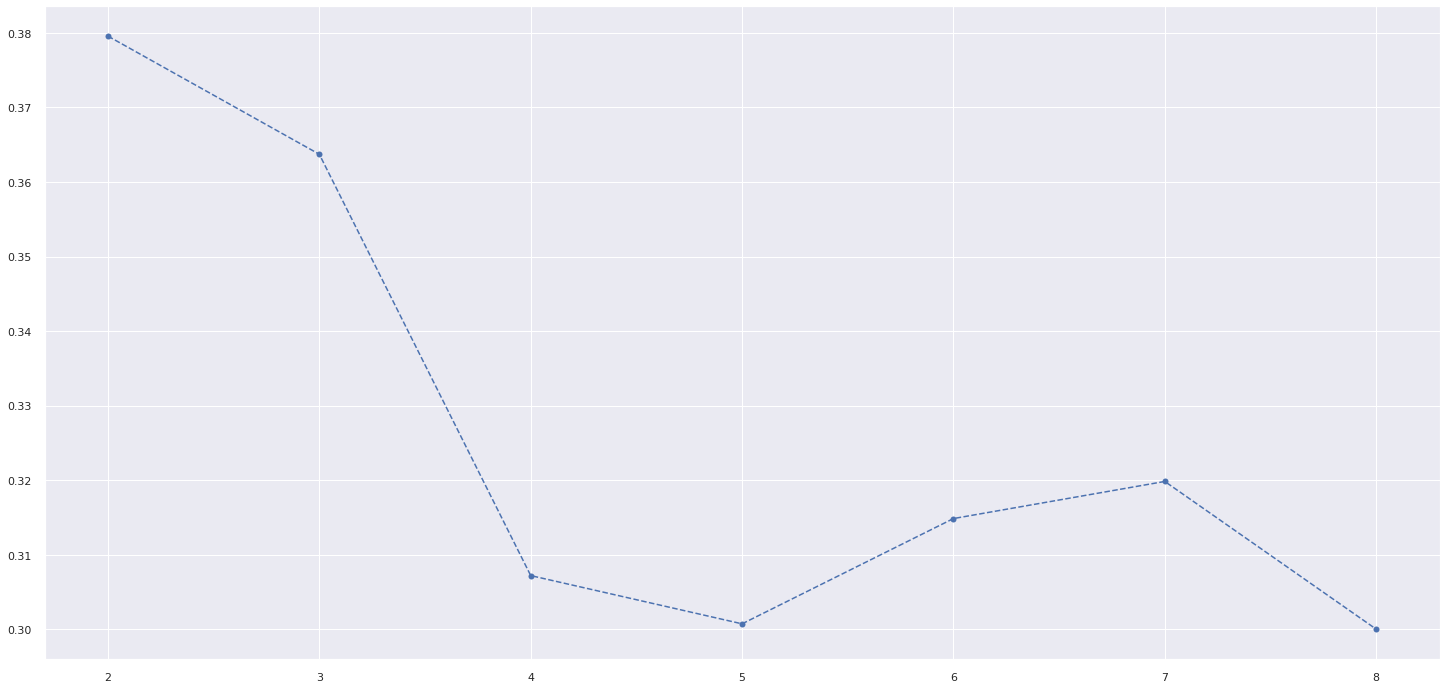

In [65]:
plt.plot(clusters, silhouette_list, linestyle='--', marker='o', color='b');

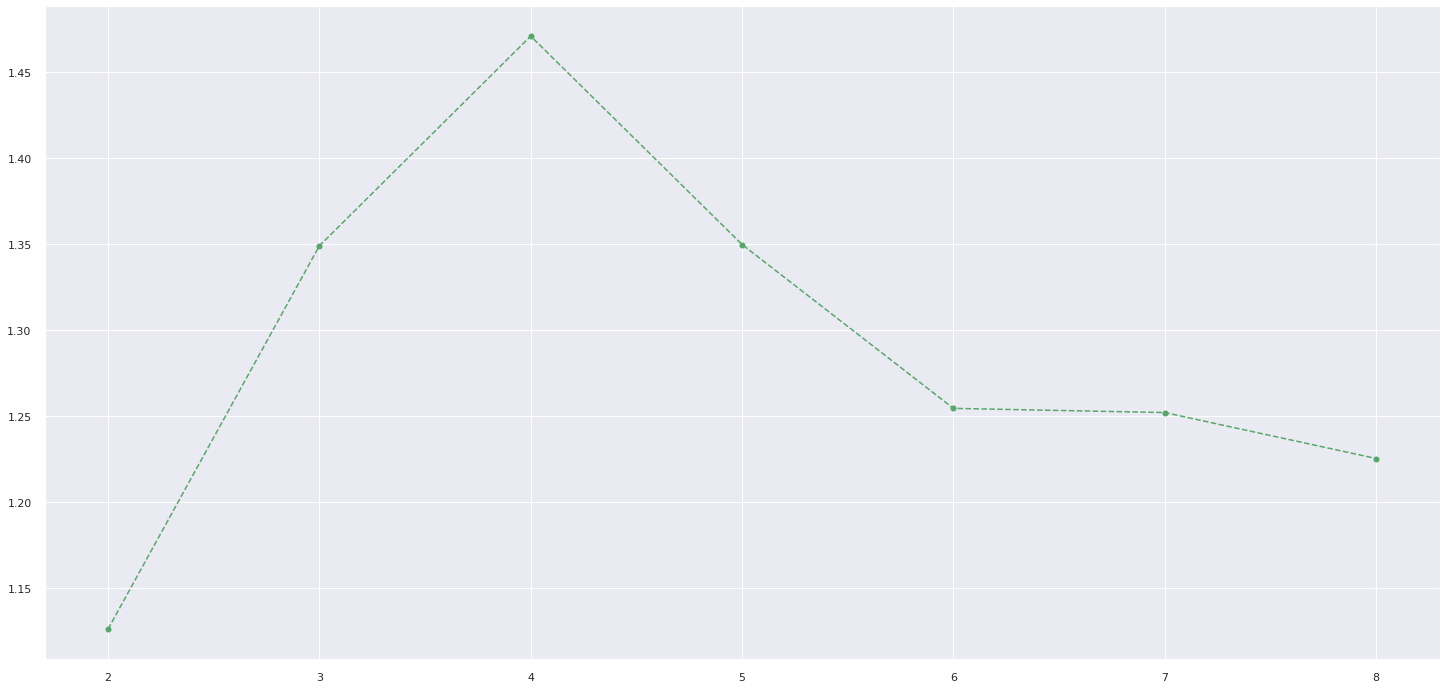

In [66]:
plt.plot(clusters, davies_list, linestyle='--', marker='o', color='g');


# 8.0 Hyperparameter fine tuning

In [67]:
df8=df7.copy()

## 8.1 Within-Cluster Sum of Square (WSS)
    - Measure how compact the clusters are

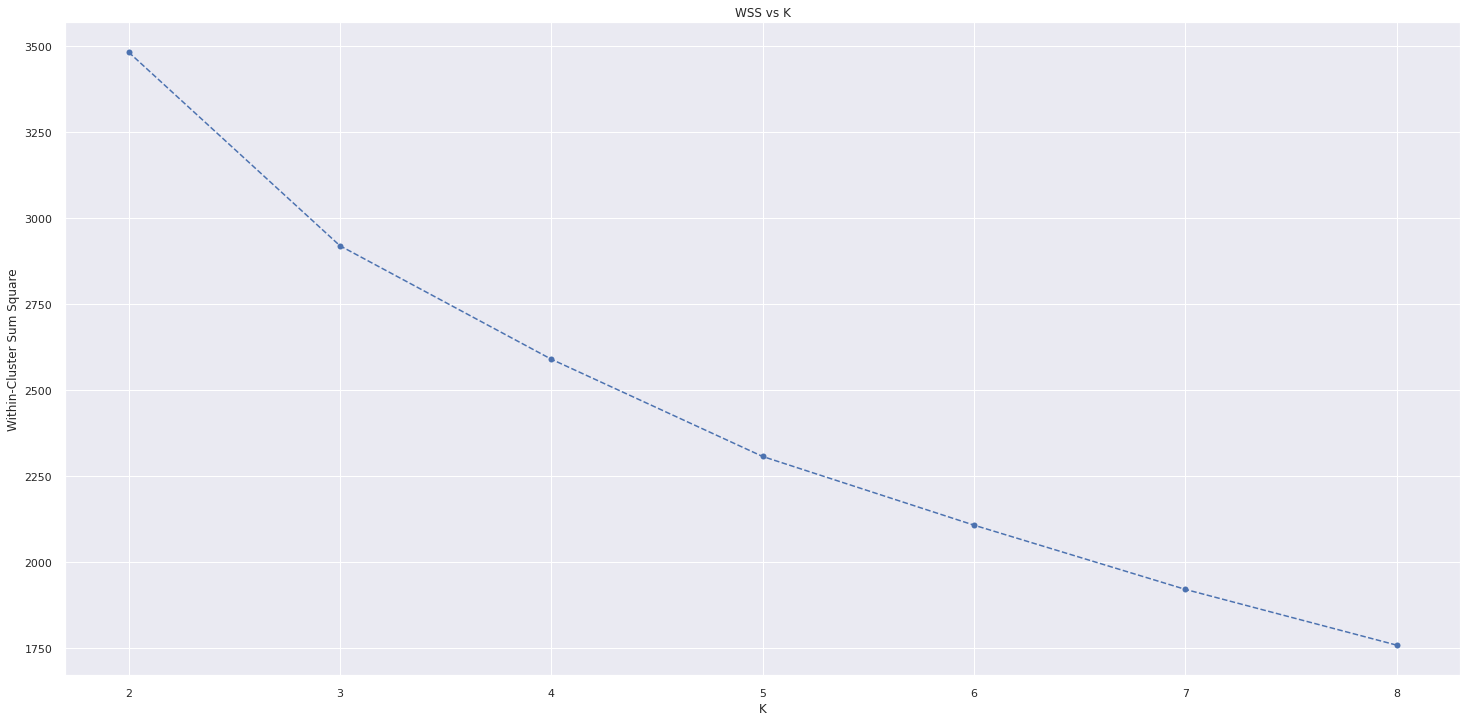

In [68]:
wss = []
for k in clusters:
    # model definition
    kmeans=c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model Training
    kmeans.fit(X)

    # validation
    wss.append( kmeans.inertia_)

# plot wss elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum Square');
plt.title('WSS vs K');

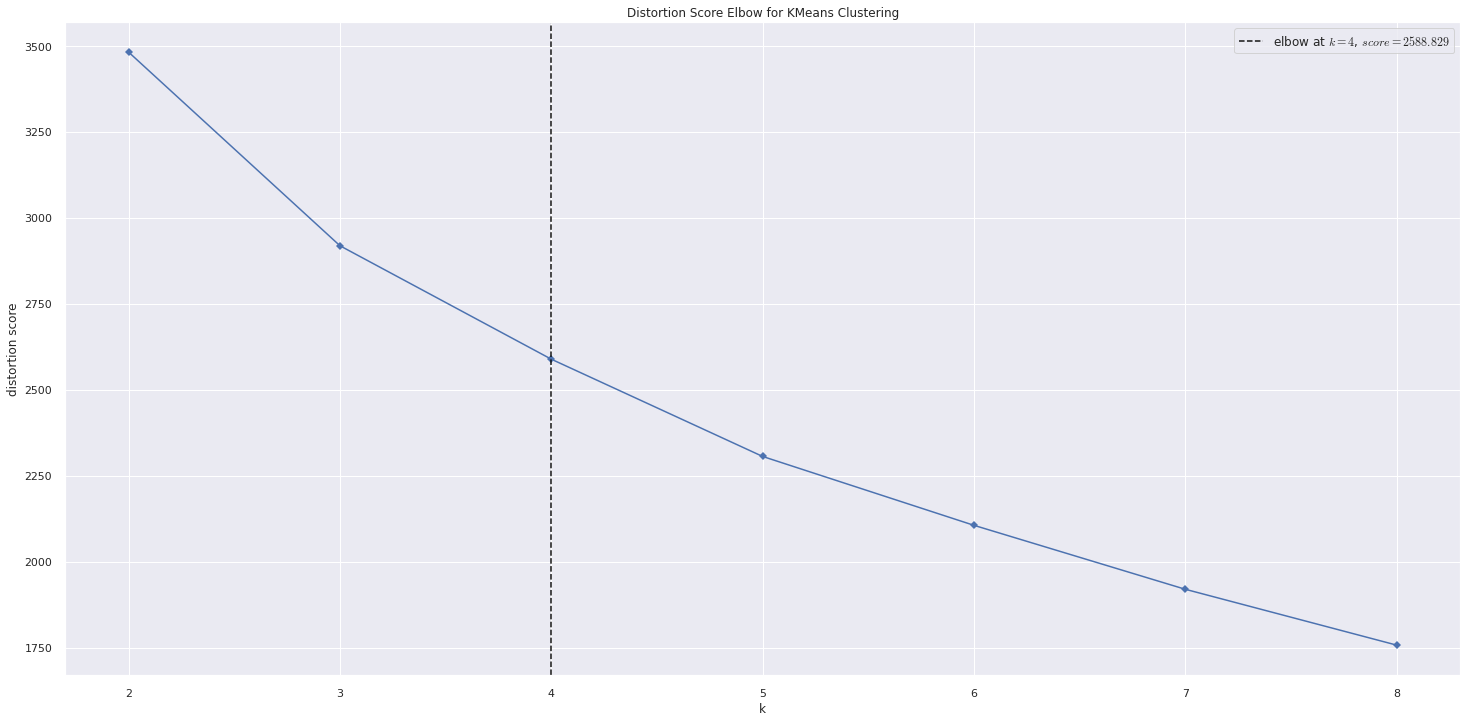

In [69]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False );
kmeans.fit(X)
kmeans.show();

## 8.2 Sillhouette Score
    - Measure how good is the separation btw clusters

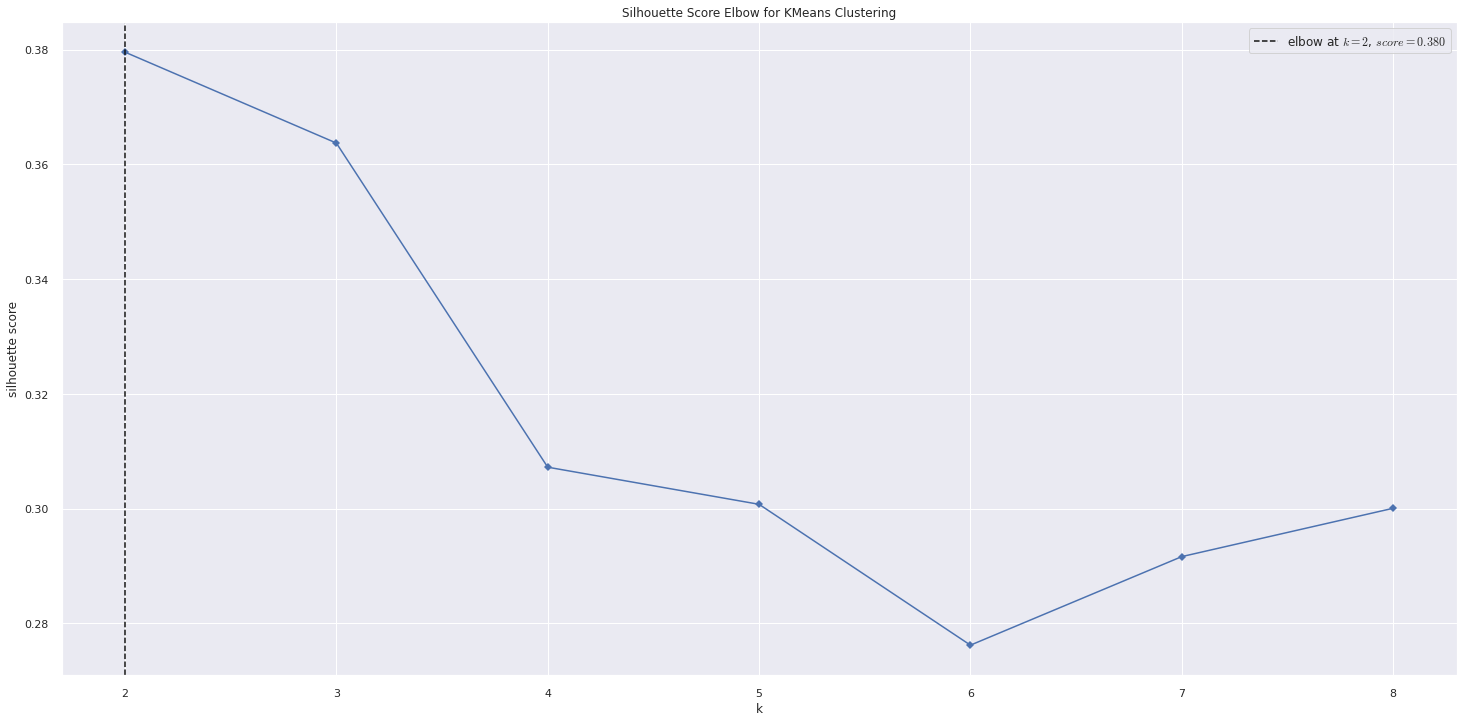

In [70]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

# 9.0 Cluster Analysis

In [71]:
df9=df8.copy()


# 10.0 Deploy to production

In [72]:
df10=df9.copy()
